In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2023-05-16 14:06:24.613965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=50)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        if image_path == "no":
            pass
        else:
            if label == "BENIGN":
                labels.append(0)
            else:
                labels.append(1)
            # labels.append(label)
            image = cv2.imread(image_path, 0)
            gray_img_eqhist=cv2.equalizeHist(image)
            gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
            image = tf.image.resize(gray_clahe_image, (299, 299)).numpy().astype("uint8")
            images.append(image)
    return np.array(images), np.array(labels)

In [4]:
train = pd.read_csv("../CBIS-DDSM/csv/mass_train_updated.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/mass_test_updated.csv", index_col=0)

In [5]:
new_dataset_train_path = "../image_dataset/mass_dataset/cropped_images/train/"
new_dataset_val_path = "../image_dataset/mass_dataset/cropped_images/validation/"
new_dataset_test_path = "../image_dataset/mass_dataset/cropped_images/test/"
BATCH_SIZE = 256
IMG_SIZE = 299
tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            
                                                              image_size=(IMG_SIZE, 
                                                                          IMG_SIZE))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(IMG_SIZE,
                                                                               IMG_SIZE))

images, labels = generate_test_data(test, image_type_path="cropped image file path")

Found 1214 files belonging to 2 classes.
Metal device set to: Apple M1
Found 243 files belonging to 2 classes.


2023-05-16 14:06:27.540206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 14:06:27.540845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 341 files belonging to 2 classes.


2023-05-15 14:57:46.861742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-15 14:57:46.862088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [341]
	 [[{{node Placeholder/_0}}]]


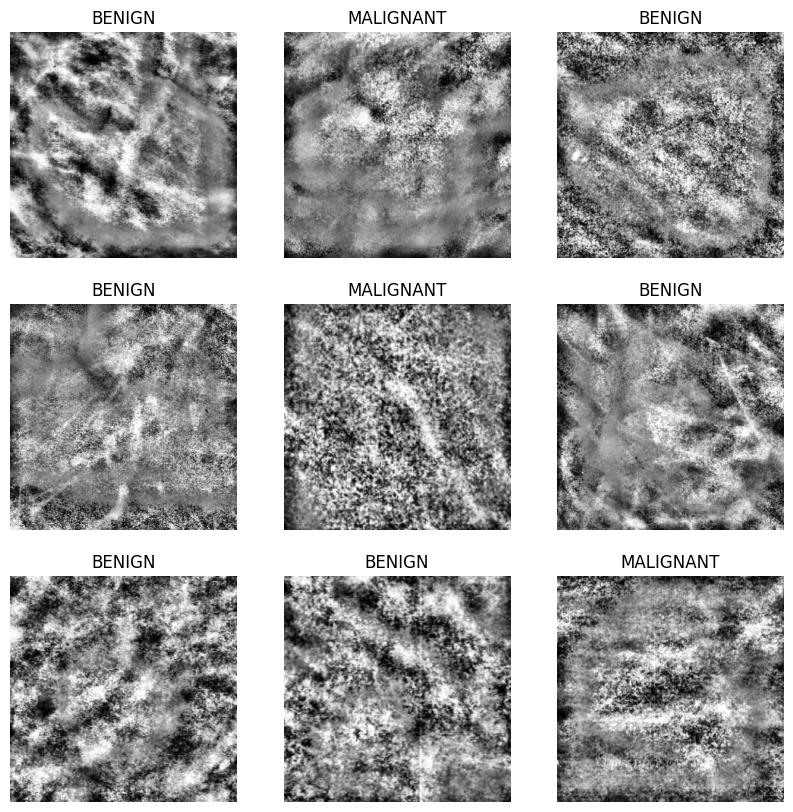

In [21]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)])

# preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              104960

In [ ]:
history = model.fit(tf_train_dataset,
                    epochs=100,
                    batch_size=256,
                    validation_data=tf_test_dataset)

mets = model.evaluate(tf_test_dataset)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/100


2023-05-16 14:06:34.157099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1214]
	 [[{{node Placeholder/_4}}]]
2023-05-16 14:06:34.157584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1214]
	 [[{{node Placeholder/_4}}]]
2023-05-16 14:06:36.363249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.5453

2023-05-16 14:07:03.810167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [341]
	 [[{{node Placeholder/_0}}]]
2023-05-16 14:07:03.812329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-16 14:07:04.860463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 38s 7s/step - loss: 0.7550 - accuracy: 0.5453 - val_loss: 0.6771 - val_accuracy: 0.5601
Epoch 2/100
5/5 [==============================] - 43s 8s/step - loss: 0.6623 - accuracy: 0.6046 - val_loss: 0.6641 - val_accuracy: 0.5865
Epoch 3/100
5/5 [==============================] - 41s 7s/step - loss: 0.6381 - accuracy: 0.6285 - val_loss: 0.6828 - val_accuracy: 0.5337
Epoch 4/100
5/5 [==============================] - 38s 7s/step - loss: 0.6264 - accuracy: 0.6343 - val_loss: 0.6534 - val_accuracy: 0.5865
Epoch 5/100
5/5 [==============================] - 40s 8s/step - loss: 0.5970 - accuracy: 0.6903 - val_loss: 0.6542 - val_accuracy: 0.5924
Epoch 6/100
5/5 [==============================] - 45s 9s/step - loss: 0.5568 - accuracy: 0.7109 - val_loss: 0.6737 - val_accuracy: 0.5865
Epoch 7/100
5/5 [==============================] - 42s 8s/step - loss: 0.5576 - accuracy: 0.7216 - val_loss: 0.6658 - val_accuracy: 0.6070
Epoch 8/100
5/5 [======================

In [38]:
mets = model.evaluate(tf_test_dataset)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

2/2 [==============================] - 6s 1s/step - loss: 0.9872 - accuracy: 0.7155
loss: 0.9871988892555237 
accuracy: 71.5542 %


In [51]:
y_pred = model.predict(tf_test_dataset)

print(classification_report(y_true=labels, y_pred=np.round(np.squeeze(y_pred))))

2/2 [==============================] - 7s 3s/step
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       194
           1       0.43      0.35      0.38       147

    accuracy                           0.52       341
   macro avg       0.50      0.50      0.50       341
weighted avg       0.51      0.52      0.51       341



In [42]:
confusion_matrix(labels, np.round(np.squeeze(y_pred))) 

array([[127,  67],
       [ 96,  51]])

In [43]:
history = model.history

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'accuracy'

| Patient ID | Study | Series | Modality | Laterality | View | Image Type | 
| --- | --- | --- | --- | --- | --- | --- |
| P_00001 | Calc-Training | LEFT_CC | MG | L | MLO | Full Mammogram |
| P_00001 | Calc-Training | LEFT_CC | MG | L | MLO | Cropped Image |
| P_00001 | Calc-Training | LEFT_MLO | MG | L | CC | Full Mammogram |
| P_00001 | Calc-Training | LEFT_MLO | MG | L | CC | Cropped Image |
| P_00002 | Mass-Training | RIGHT_CC | MG | R | MLO | Full Mammogram |
| P_00002 | Mass-Training | RIGHT_CC | MG | R | MLO | Cropped Image |
| P_00002 | Mass-Training | RIGHT_MLO | MG | R | CC | Full Mammogram |
| P_00002 | Mass-Training | RIGHT_MLO | MG | R | CC | Cropped Image |